In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

from IPython import display
# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title("Decision Boundary")
    display.clear_output(wait=True)
    display.display(plt.gcf())

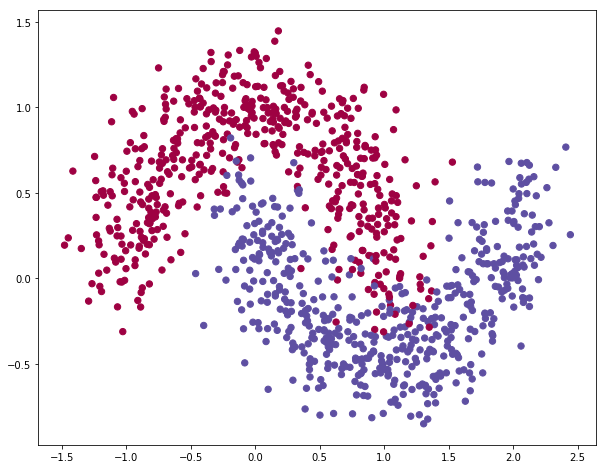

In [8]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1024, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [9]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters
epsilon = 0.0001 # learning rate for gradient descent
reg_lambda = 0.001 # regularization strength

### Excercise 3: Artificial Neural Network
In this exercise we will implement a simple neural network with one input, one hidden and one output layer.

### 3.1

### Implement the Softmax function

The softmax function, AKA normalized exponential function, is a generalization of the logistic function that "squashes" a K-dimensional vector $\mathbf {z}$ of arbitrary real values to a K-dimensional vector $\sigma (\mathbf {z})$ of real values in the range [0, 1] that add up to 1.
This is very useful for classification problems, because it allows us to obtain a valid probability distribution over all possible classes - a categorical probability distribution.

$$\sigma(z)_{j} = {e^{z_{j}} \over \sum_{k=1}^{K}e^{z_{k}}}$$

In [3]:
def softmax(v):
    exp_v = np.exp(v)
    return exp_v/np.sum(exp_v, axis=1, keepdims=True)

In [11]:
assert np.linalg.norm(softmax([[3,5,1]]) - np.array([[ 0.1173,  0.8668,  0.01587]])) < 1e-3
print('done')

done


### 3.2

Let x be our 2-dimensional input data. Our neural network processes this data layer by layer to calculate the prediction $\tilde{y}$ for each sample. This process of computing predictions from input data is called forward propagation. The steps are:

$z_{1}=xW_{1}+b_{1}$

$a_{1}=tanh(z_{1})$

$z_{2}=a_{1}W_{2}+b_{2}$

$a_{2}=\tilde{y}=softmax(z_{2})$

Here, $W_{1}$, $b_{1}$, $W_{2}$, $b_{2}$ are learnable parameters of the neural network. 

Implement the forward propagation process

In [4]:
def forward_propagate(_X, _W1, _b1, _W2, _b2):
    ## 1st NN layer
    # multiply input by weights, add bias
    z1 = np.dot(_X, _W1) + _b1
    # apply np.tanh activation function
    a1 = np.tanh(z1)
    
    ## 2nd NN layer
    # multiply output of previous layer by weights, add bias
    z2 = np.dot(a1, _W2) + _b2
    # apply softmax and return the result
    probs = softmax(z2)
    
    return probs

In [65]:
TW1 = np.ones((2,3))
Tb1 = np.ones((1,3))
TW2 = np.ones((3,2))
Tb2 = np.array([[-5, 5]])
TsX = np.array([[1, -1],[-1, 1]])
TR = np.array([[  4.5397e-05,   9.9995e-01],
              [  4.5397e-05,   9.9995e-01]])

assert np.linalg.norm(forward_propagate(TsX, TW1, Tb1, TW2, Tb2) - TR ) < 1e-4
print('done')

done


### 3.3

Now that we have a forward propagation function outputting class probabilities, we need a function that returns the most probable class for each sample.

In [5]:
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    probs = forward_propagate(x, W1, b1, W2, b2)
    predictions = np.argmax(probs, axis=1)
    return predictions

In [67]:
Tmodel = {'W1':TW1, 'W2':TW2, 'b1':Tb1, 'b2':Tb2}

In [68]:
assert list(predict(Tmodel, TsX)) == [1,1]
print('done')

done


### 3.4

Everything is done and we are ready to train our model! The loss and the backprop have been implemented here for you.

In [6]:
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    probs = forward_propagate(X, W1, b1, W2, b2)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

def build_model(nn_hdim, num_passes=2000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 100 == 0:
            plot_decision_boundary(lambda x: predict(model, x))
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    display.clear_output(wait=True)
    return model

In [4]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True, num_passes=2000)

NameError: name 'np' is not defined

### 3.5

Now apply the MLP model to another dataset. Now the amount of classes = 3, so don't forget to adjust the nn_output_dim variable accordingly.

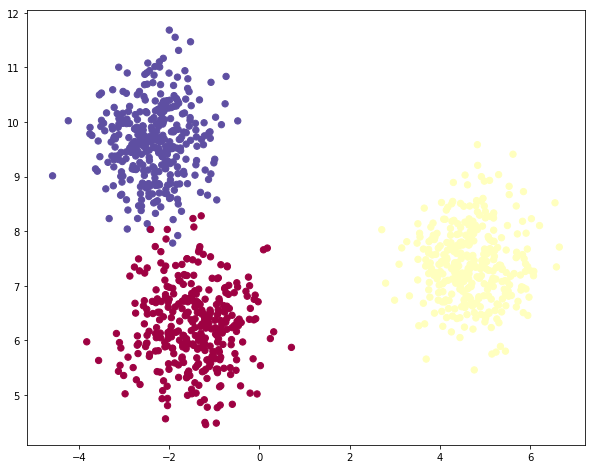

In [8]:
X, y = sklearn.datasets.make_blobs(n_samples=1024, n_features=2, 
                                   random_state=27, cluster_std=0.7)
# Generate a dataset and plot it
np.random.seed(0)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [9]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 3 # output layer dimensionality

# Gradient descent parameters
epsilon = 0.0001 # learning rate for gradient descent
reg_lambda = 0.001 # regularization strength

NameError: name 'X' is not defined

In [ ]:
# Build a model with a 3-dimensional hidden layer
model = build_model(1500, print_loss=True, num_passes=2000)